In [2]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import openslide
import random
import cv2
import matplotlib
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torchvision.models as models
import torchvision
import torch
import torch.nn as nn
from torch.optim import Adam
from torch import LongTensor as LongTensor
from torch import FloatTensor as FloatTensor

/mnt/c/Users/33631/Documents/Etudes/centrale 3A/Deep Learning for medical Imaging/prostate_cancer_detection/new_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_set_path = "Data/raw_data/train.csv"
test_set_path = "Data/raw_data/test.csv"
test_images_folder = "Data/raw_data/test/test/"
train_images_folder = "Data/raw_data/train/train/"
train_mask_folder = "Data/raw_data/train_label_masks/train_label_masks/"
train_tiles_folder = "Data/processed_data/tiles_train/"

### Road Map:

we will predict the gleason scores and then convert it to isup grade

## Usefull stuff

In [4]:
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

## Load data and explore data

In [5]:
initial_train_set = pd.read_csv(train_set_path)
test_set = pd.read_csv(test_set_path)

In [6]:
gleason_score_2_idx = dict([(k,v) for v,k in enumerate(list(initial_train_set.gleason_score.unique()))])
idx_2_gleason_score = {(v,k) for v,k in gleason_score_2_idx.items()}

In [7]:
# let's check the correspondance between isup and gleason
(initial_train_set[['isup_grade','gleason_score']]
    .groupby('isup_grade')
    .agg({'gleason_score': lambda x: x.unique()})
)

,gleason_score
isup_grade,
0,"[negative, 0+0]"
1,[3+3]
2,[3+4]
3,[4+3]
4,"[4+4, 3+5, 5+3]"
5,"[5+4, 4+5, 5+5]"


In [8]:
# count isup grades
(initial_train_set[['isup_grade','gleason_score']]
    .groupby('isup_grade')
    .count()
)

,gleason_score
isup_grade,
0,85
1,85
2,37
3,45
4,42
5,46


In [9]:
# image provider
(initial_train_set[['data_provider','gleason_score']]
    .groupby('data_provider')
    .count()
)

,gleason_score
data_provider,
karolinska,194
radboud,146


## Prepare Data

In [10]:
validation_ratio = 0.2

X = initial_train_set.drop(columns = ['gleason_score', 'isup_grade'])
y = initial_train_set[['isup_grade','gleason_score']]
train_samples, validation_samples, train_labels, validation_labels = train_test_split(X,y, test_size=validation_ratio, random_state=0, shuffle=True, stratify=y)

train_set = pd.concat([train_samples, train_labels], axis = 1)
validation_set = pd.concat([validation_samples, train_labels], axis = 1)

In [11]:
train_set.sample(3)

,image_id,data_provider,isup_grade,gleason_score
65,77db80dce3763d46aacb3e82c59bc325,karolinska,0,0+0
71,a04846524f108bb046c4e39f3dcce5d3,radboud,5,4+5
175,4695453e7447f0c2266995c8dc4c0f78,radboud,3,4+3


## Visualisations

In [12]:
def visualise_mask_and_image(id, level = 3): # last level by default
    line = train_set.iloc[id]

    data_provider = line.data_provider
    isup_grade = line.isup_grade
    gleason_score = line.gleason_score
    image_id = line.image_id

    image = openslide.OpenSlide(train_images_folder+image_id+'.tiff')
    print(image.level_dimensions)
    image_data = image.read_region((0,0), image.level_count - 1, image.level_dimensions[-1])
    try:
        mask = openslide.OpenSlide(train_mask_folder+image_id+'.tiff')
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
    except:
        print('no mask for this image')
        mask = None
        mask_data = None


    fig, axes = plt.subplots(1,2, figsize=(8,8))
    axes[0].imshow(image_data)
    axes[1].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)

    title = f"gleason score: {gleason_score} - isup grade: {isup_grade} \n data provider: {data_provider}"
    fig.suptitle(title, fontsize=14)
    
    mask.close()
    image.close()
    fig.tight_layout()
    plt.show()


((18924, 33498), (4731, 8374), (1182, 2093))


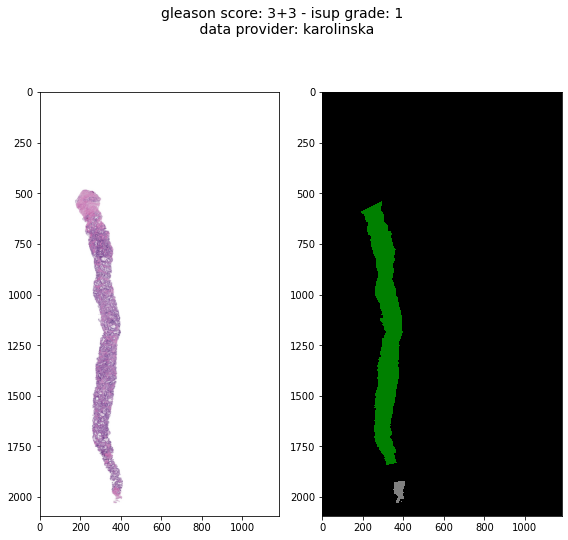

In [13]:
visualise_mask_and_image(1)

((9472, 22016), (2368, 5504), (592, 1376))


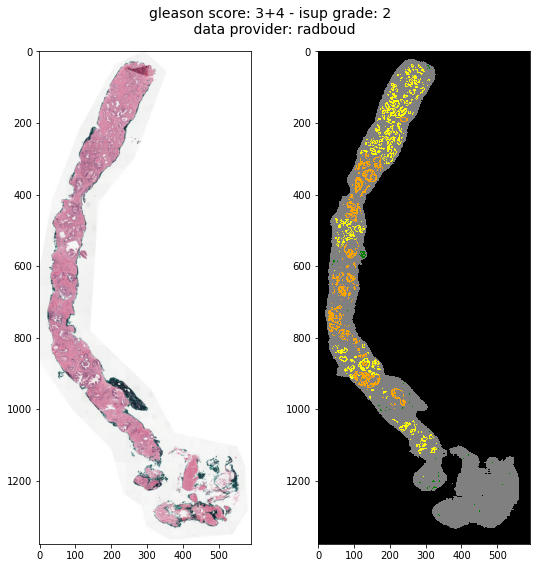

In [14]:
visualise_mask_and_image(2)

((21912, 23507), (5478, 5876), (1369, 1469))


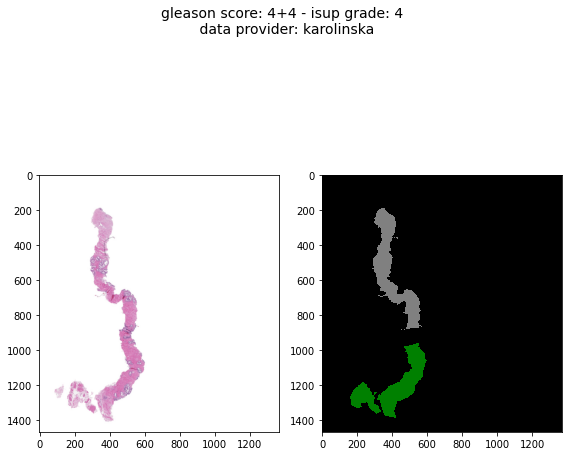

In [46]:
visualise_mask_and_image(15)

In [15]:
def get_tiles(image, n_tiles = 16, tile_shape = 128, level = 1):
    dimensions = image.level_dimensions[level]
    img = np.array(image.read_region((0,0), level, dimensions))
    offset_0 = tile_shape-dimensions[1]%tile_shape
    offset_1 = tile_shape-dimensions[0]%tile_shape

    pad_0 = (offset_0//2, offset_0//2+offset_0%tile_shape%2)
    pad_1 = (offset_1//2, offset_1//2+offset_1%2)
    img = np.pad(img, pad_width = (pad_0, pad_1, (0,0)), mode = 'constant',constant_values = 255)

    img = img.reshape(img.shape[0] // tile_shape, tile_shape, img.shape[1] // tile_shape, tile_shape, 4)
    img = img.transpose(0,2,1,3,4).reshape(-1, tile_shape, tile_shape, 4)


    indexes = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:n_tiles]
    tiles  = img[indexes]
    new_image = np.zeros(((n_tiles//4)*128,(n_tiles//4)*128,4))
    for i in range(tiles.shape[0]):
        col = i%(n_tiles//4)
        row = i//(n_tiles//4)
        new_image[row*128:(row+1)*128,col*128:(col+1)*128,:] = tiles[i]
    new_image = new_image.astype('uint8')
    return(new_image)

In [16]:
from PIL import Image
def create_tiles(df):
    for i in tqdm(range(df.shape[0]), position = 0):
        value = df.iloc[i]
        id = value.image_id
        if os.path.isfile(train_tiles_folder+id+".jpeg"):
            continue
        image = openslide.OpenSlide(train_images_folder+id+".tiff")
        tile_image = get_tiles(image)
        tile_image = Image.fromarray(tile_image)
        tile_image = tile_image.convert('RGB')
        tile_image.save(train_tiles_folder+id+".jpeg")
        image.close()


In [49]:
create_tiles(train_set)

100%|██████████| 272/272 [00:01<00:00, 259.16it/s]


## Create Data Set

In [17]:
gleason_number_of_values = len(gleason_score_2_idx)

In [40]:
class TilesDatasetNew(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, dir, n_tiles = 16, tile_shape = 128, transform=None):
        """
        Args:
            df (dataframe): Path to the csv file with annotations.
            dir (string): Directory with tiles images
            transform (callable, optional): Optional transform to be applied
        """
        self.df = df
        self.dir = dir
        self.transform = transform
        self.n_tiles = n_tiles
        self.tile_shape = tile_shape

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        value = self.df.iloc[idx]
        image_id = value.image_id
        # get image
        image = openslide.OpenSlide(self.dir+image_id+".tiff")
        tile_image = get_tiles(image, n_tiles = self.n_tiles, tile_shape = self.tile_shape)
        tile_image = Image.fromarray(tile_image).convert('RGB')
        tile_image = torchvision.transforms.functional.to_tensor(np.array(tile_image))
        tile_image = tile_image.permute(0, 1, 2)
        # compute label
        label = torch.tensor(gleason_score_2_idx[value.gleason_score])
        if self.transform:
            tile_image = self.transform(tile_image)
        return tile_image, label

In [22]:
class TilesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, dir, transform=None):
        """
        Args:
            df (dataframe): Path to the csv file with annotations.
            dir (string): Directory with tiles images
            transform (callable, optional): Optional transform to be applied
        """
        self.df = df
        self.dir = dir
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        value = self.df.iloc[idx]
        image_id = value.image_id
        # compute file
        img_file = self.dir+image_id+'.jpeg'
        # get image
        tile_image = np.array(Image.open(img_file))
        tile_image = torchvision.transforms.functional.to_tensor(tile_image)
        tile_image = tile_image.permute(0, 1, 2)
        # compute label
        label = torch.tensor(gleason_score_2_idx[value.gleason_score])
        if self.transform:
            tile_image = self.transform(tile_image)
        return tile_image, label

In [52]:
class ResNetDetector(nn.Module):
    def __init__(self, output_shape):
        super(ResNetDetector, self).__init__()

        self.softmax = nn.Softmax(dim=1)
        self.dense = nn.Linear(1280, output_shape)

        self.resnet =  models.efficientnet_b0(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        
    def forward(self, img):
        feat = self.resnet(img).squeeze()
        gleason_logit = self.dense(feat)
        gleason_prob = self.softmax(gleason_logit)
        return gleason_prob

In [50]:
# 1 epoch training

def train_one_epoch(model, trainloader, validationloader, optimizer): 
    losses = []
    for (features, target) in tqdm(trainloader):
        features = features.to(device)
        target= target.to(device)
        optimizer.zero_grad()
        predictions = model(features)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(predictions, target)
        losses.append(float(loss))
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
      for (features, target) in (validationloader):
          features.to(device)
          target.to(device)
          predictions = model(features)
          predicted_classes = torch.argmax(predictions, dim=1)
          accuracy = int(torch.sum(predicted_classes==target))/len(predicted_classes)
          criterion = nn.CrossEntropyLoss()
          loss = float(criterion(predictions, target))
          
          print('average train loss: ', np.mean(losses))
          print('validation loss: ', loss)
          print('validation accuracy: ', accuracy)

    return(loss, accuracy)

In [56]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device = 'cpu'

In [57]:
conv_model = ResNetDetector(gleason_number_of_values).to(device)
optimizer = torch.optim.Adam(conv_model.parameters())
training_set = TilesDatasetNew(train_set, train_images_folder)

In [58]:
# split train and validation set
data_set = training_set
train_len = int(len(data_set)*0.9)
training_set, validation_set = torch.utils.data.random_split(data_set, [train_len, len(data_set) - train_len])

trainloader = torch.utils.data.DataLoader(training_set, batch_size=2, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=len(validation_set), shuffle=True)


optimizer = torch.optim.Adam(conv_model.parameters())
loss_list = []
accuracy_list = []
for epoch in range(0, 25):
    loss, accuracy = train_one_epoch(conv_model , trainloader, validationloader, optimizer)
    loss_list.append(loss)
    accuracy_list.append(accuracy)

100%|██████████| 122/122 [24:58<00:00, 12.28s/it]


average train loss:  2.327516326161682
validation loss:  2.417083978652954
validation accuracy:  0.10714285714285714


  0%|          | 0/122 [01:19<?, ?it/s]


KeyboardInterrupt: 

## Next steps

In [ ]:
val_sets, train_sets = [], []
FOLDS = 5
val_splits = np.int32((np.arange(FOLDS + 1)/FOLDS) * len(train_set))
val_indices = [[val_splits[i], val_splits[i+1]] for i in range(FOLDS)]

for fold in tqdm(range(FOLDS)):
    val_idx = val_indices[fold]
    if fold == FOLDS - 1: val_idx[1] -= 1
    val_sets.append(train_set[val_idx[0]:val_idx[1]])
    train_sets.append(pd.concat([train_set[:val_idx[0]], train_set[val_idx[1]:]]))

100%|██████████| 5/5 [00:00<00:00, 316.08it/s]


In [ ]:
(np.arange(FOLDS + 1)/FOLDS) * len(train_set)

array([  0. ,  54.4, 108.8, 163.2, 217.6, 272. ])